# Machine Learning in Python - Project 1

Due Friday, April 15th by 5 pm UK local time.

*include contributors names here*

## 0. Setup

In [94]:
# Add any additional libraries or submodules below

# Display plots inline
%matplotlib inline

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns


##missingness library
import missingno

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules
import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier

In [95]:
# Load data
d = pd.read_csv("../hotel.csv")
d.head()

##create copy of data
df = d.copy()

## 1. Introduction

*This section should include a brief introduction to the task and the data (assume this is a report you are delivering to a client). If you use any additional data sources, you should introduce them here and discuss why they were included.*

*Briefly outline the approaches being used and the conclusions that you are able to draw.*

## 2. Exploratory Data Analysis and Feature Engineering

*Include a detailed discussion of the data with a particular emphasis on the features of the data that are relevant for the subsequent modeling. Including visualizations of the data is strongly encouraged - all code and plots must also be described in the write up. Think carefully about whether each plot needs to be included in your final draft - your report should include figures but they should be as focused and impactful as possible.*

*Additionally, this section should also implement and describe any preprocessing / feature engineering of the data. Specifically, this should be any code that you use to generate new columns in the data frame `d`. All of this processing is explicitly meant to occur before we split the data in to training and testing subsets. Processing that will be performed as part of an sklearn pipeline can be mentioned here but should be implemented in the following section.*

*All code and figures should be accompanied by text that provides an overview / context to what is being done or presented.*

**The paper states that no missing data is present**. Specifically, they mention that Null of "Missing" data in the company and agent category are actually their own category specifying that no company or agent was used. As such we will create a new category for these.

In [96]:
##Fill misssing data with new category called "Not Used"
missing_cols = ["company", "agent"]
for i in missing_cols:
    df[i] = df[i].fillna("Not Used") ##Fill "NA" with new variable
    df[i] = df[i].astype('str') ##Change to str for categorical classification
    df[i] = df[i].astype('object') ##Change to object for categorical classification
    
print("Number of Missing Company Values After 'Fill':")
print(df["company"].isna().sum())
print(df["company"].nunique())

Number of Missing Company Values After 'Fill':
0
353


Removing duplicates: There is the slight chance that two different bookings have the exat same data since we are not given a customer ID. However, since the data includes lead_time, arrival_date_year, arrival_date_week_number, and other very specific identifying characteristics, we can be confident that any duplicates are actual duplicates and not two different customers with the same data

In [97]:
##drop duplicates
df = df.drop_duplicates(keep = 'first')

Creating Binary Variables for "Children Present", "Baby Present", "Agent Used", "Company Used"

In [98]:
##create new variable for children present, baby present, agent used, company used
binary_nums = ["children_present", "baby_present"]
binary_cats = ["company_used", "agent_used"]
nonbinary_nums = ["children", "babies"]
nonbinary_cats = ["company", "agent"]

##for baby and children (numericals)
for i in range(len(binary_nums)):
    df[binary_nums[i]] = np.where(df[nonbinary_nums[i]] > 0, np.int64(1), np.int64(0))

##for company and agent (categoricals)
for i in range(len(binary_cats)):
    df[binary_cats[i]] = np.where(df[nonbinary_cats[i]] != 'Not Used', np.int64(1), np.int64(0))

Lastly, we will define a new column called "group_type" to characterise the type of group the booking belongs to. There will be 3 levels: 1) "Single_User": Only one adult 2) "Family": At least one adult and at least one child or baby 3) "Adult_Group": More than one adult with no children or babies.

The idea here is that different group types have different chances of cancelling. Single occupants and families book together, so they are less likely to cancel independently; however, groups of adults might have different members cancel independently, which could cause a cancellation overall.

In [99]:
df["group_type"] = np.where((df["children"] == 0) & (df["babies"] == 0) & (df["adults"] > 1), "Adult_Group",
                   np.where(((df["children"] > 0) | (df["babies"] > 0)) & (df["adults"] > 0), "Family",
                   np.where((df["children"]) == 0 & (df["babies"] == 0) & (df["adults"] == 1), "Single_User",
                   np.where(df["adults"] == 0, "Zero Adults", "Not Valid"))))



# np.where(,
#                    np.where(((df["children"] > 0) | (df["babies"] > 0)) & (df["adults"] > 0), "Family",
#                    np.where((df["children"] == 0) & (df["babies"] == 0) & (df["adults"] > 1), "Adult_Group",
#                    np.where(df["adults"] == 0, "Zero Adults", "Not Valid")))) 

We will now check what types of groups were created to confirm that our data matches the expected structure (There should not be any observations with zero adults or no children; if this is the case, it might be predictive).

In [100]:
##Count of unique types
print("Count of Unique Types:")
print(df.group_type.value_counts())

print("\n")
print("Sum of Counts:")
print(df.group_type.value_counts().sum())

print("Total Observations:")
print(df.shape[0])

Count of Unique Types:
Adult_Group    61863
Single_User    16180
Family          8872
Zero Adults      219
Not Valid          4
Name: group_type, dtype: int64


Sum of Counts:
87138
Total Observations:
87138


Overall, the total number of unique counts matches the observations, so the column has been created correctly. As we can see, there are groups for "Zero Adults" and "Not Valid". We need to inspect these cases to see what is happening; however, given the "Not Valid" group only has 4 observations, we can likely drop.

In [101]:
print("'Not Valid' Groups:")
print(df[["adults", "children", "babies"]].iloc[np.where(df["group_type"] == "Not Valid")])

print("\n")
print("'Zero Adult' Groups:")
print(df[["adults", "children", "babies"]].iloc[np.where(df["group_type"] == "Zero Adults")])

'Not Valid' Groups:
       adults  children  babies
40600       2       NaN       0
40667       2       NaN       0
40679       3       NaN       0
41160       2       NaN       0


'Zero Adult' Groups:
        adults  children  babies
40984        0       3.0       0
41048        0       2.0       0
41446        0       2.0       0
41952        0       2.0       0
45158        0       2.0       0
...        ...       ...     ...
117204       0       2.0       0
117274       0       2.0       0
117303       0       2.0       0
117453       0       2.0       0
118200       0       3.0       0

[219 rows x 3 columns]


As the tables above show, there "Not Valid" groups occur for the missing "children" columns. Since there are only 4, we can drop these observations since we do not expect any missing values.

The "Zero Adult" group is concerning since we would expect each reservation to require an adult. However, the definition of adult may vary at hotels (ie if adult age is 25, a 21 year-old could book, but would be considered a youth). As such, we will not drop and we will consider this it's own level. It may provide predictive value.

In [102]:
##Dropping missing "children" observations since there are only 4
print("Size Before Dropping Missing Children Observations:")
print(df.shape[0])
df = df.loc[df["children"].isna() == False,:]
print("Size After Dropping Missing Children Observations:")
print(df.shape[0])

Size Before Dropping Missing Children Observations:
87138
Size After Dropping Missing Children Observations:
87134


As we can see above, we've dropped the 4 observations with missing children data. Now that we have cleaned the data a bit, we should check for additional missingness

Missing Data Patterns:
is_canceled                         0
hotel                               0
lead_time                           0
arrival_date_year                   0
arrival_date_month                  0
arrival_date_week_number            0
arrival_date_day_of_month           0
stays_in_weekend_nights             0
stays_in_week_nights                0
adults                              0
children                            0
babies                              0
meal                                0
country                           451
market_segment                      0
distribution_channel                0
is_repeated_guest                   0
previous_cancellations              0
previous_bookings_not_canceled      0
reserved_room_type                  0
assigned_room_type                  0
booking_changes                     0
deposit_type                        0
agent                               0
company                             0
days_in_waiting_list       

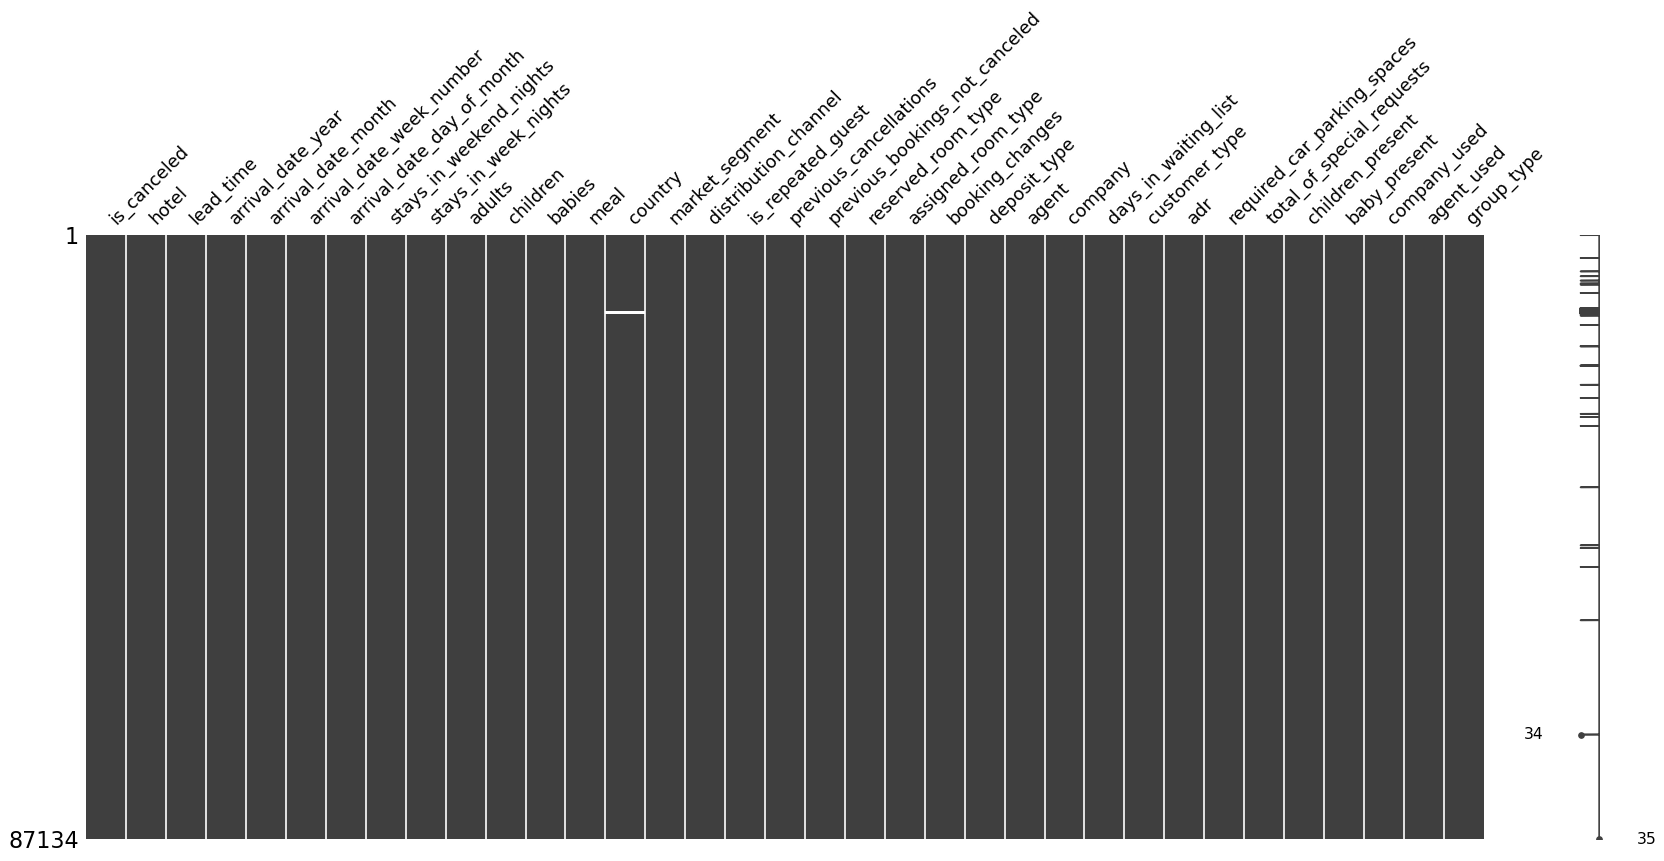

In [103]:
print("Missing Data Patterns:")
print(df.isna().sum())
# missingno.bar(df)
missingno.matrix(df)
plt.show()
# missingno.heatmap(df)

As we can see, there is missing data in the countries. We could perform imputation on these data; however, since the authors of the paper say there is not supposed to be missingness, we don't want to impute in case this missingness is predictive. As such, we will create a new level for these missing countries called "Undefined" and let that be a predictor in itself.

In [104]:
##rename missing values in "country" as undefined to let it be its own level
df["country"].loc[df["country"].isna()] = "Undefined"
print("Checking Missing Values in Country:")
print(df["country"].isna().sum())

Checking Missing Values in Country:
0


Because this is real data, there could be data entry errors, particularly with text. We will check the string values to ensure there is no improper formatting. The unique values of each string variable are printed below to check for issues with capitilzatin and spacing. The results suggest that our data sufficiently clean (no weirdly formatted strings that are actually duplicate values but misspelled) to proceed.

In [105]:
#check unique values of strings to see if any strings are formatted weird
#Exlude agent and company because we already know they are formatted correctly and they have too many levels to print
string_cols = df.drop(columns = ["agent", "company"]).select_dtypes(["object"]).columns

uniquevals = {}
for col in string_cols:
    uniquevals[col] = df[col].unique()
    
##Reformat for easy viewing
for key, value in uniquevals.items():
    print(f'{key}{value}')

hotel['Resort Hotel' 'City Hotel']
arrival_date_month['July' 'August' 'September' 'October' 'November' 'December' 'January'
 'February' 'March' 'April' 'May' 'June']
meal['BB' 'FB' 'HB' 'SC' 'Undefined']
country['PRT' 'GBR' 'USA' 'ESP' 'IRL' 'FRA' 'Undefined' 'ROU' 'NOR' 'OMN' 'ARG'
 'POL' 'DEU' 'BEL' 'CHE' 'CN' 'GRC' 'ITA' 'NLD' 'DNK' 'RUS' 'SWE' 'AUS'
 'EST' 'CZE' 'BRA' 'FIN' 'MOZ' 'BWA' 'LUX' 'SVN' 'ALB' 'IND' 'CHN' 'MEX'
 'MAR' 'UKR' 'SMR' 'LVA' 'PRI' 'SRB' 'CHL' 'AUT' 'BLR' 'LTU' 'TUR' 'ZAF'
 'AGO' 'ISR' 'CYM' 'ZMB' 'CPV' 'ZWE' 'DZA' 'KOR' 'CRI' 'HUN' 'ARE' 'TUN'
 'JAM' 'HRV' 'HKG' 'IRN' 'GEO' 'AND' 'GIB' 'URY' 'JEY' 'CAF' 'CYP' 'COL'
 'GGY' 'KWT' 'NGA' 'MDV' 'VEN' 'SVK' 'FJI' 'KAZ' 'PAK' 'IDN' 'LBN' 'PHL'
 'SEN' 'SYC' 'AZE' 'BHR' 'NZL' 'THA' 'DOM' 'MKD' 'MYS' 'ARM' 'JPN' 'LKA'
 'CUB' 'CMR' 'BIH' 'MUS' 'COM' 'SUR' 'UGA' 'BGR' 'CIV' 'JOR' 'SYR' 'SGP'
 'BDI' 'SAU' 'VNM' 'PLW' 'QAT' 'EGY' 'PER' 'MLT' 'MWI' 'ECU' 'MDG' 'ISL'
 'UZB' 'NPL' 'BHS' 'MAC' 'TGO' 'TWN' 'DJI' 'STP' 'KNA' 'ETH'

Now We'd like to check the proportion of cancelations and kept reservations per category in each categorical variable. The data will help us identify potentially important variables

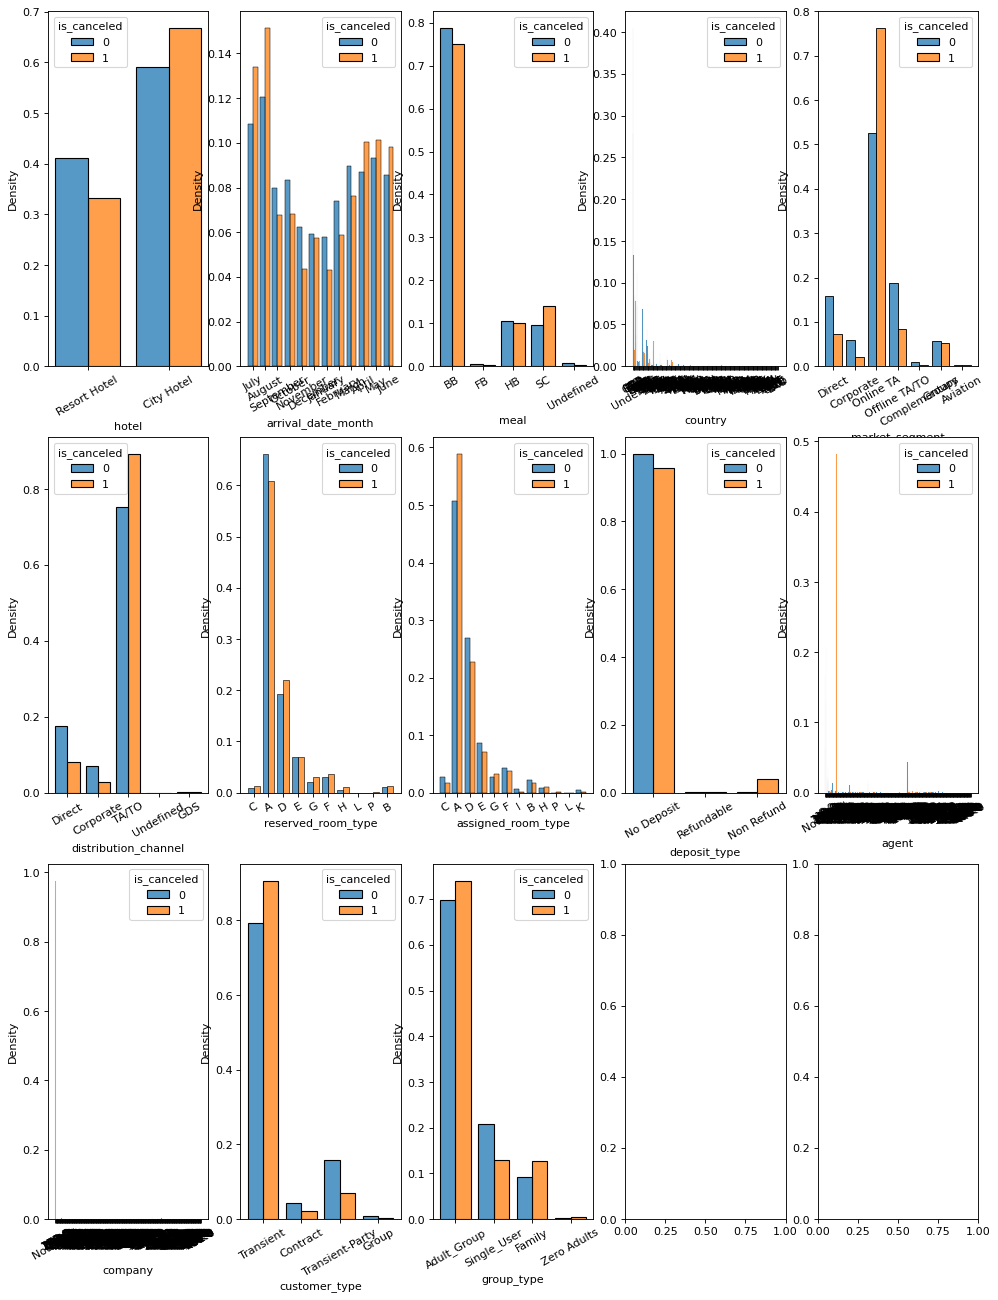

In [106]:
##plot categorical variables split by cancellation status
fig, ax = plt.subplots(ncols = 5, nrows =3, figsize = (15, 20))
ax = ax.ravel()
obj_cols = df.select_dtypes(["object", "category"]).columns 

for i in range(len(obj_cols)):
#     g = sns.countplot(x=obj_cols[i], hue = "is_canceled", data = df, ax = ax[i])
    g = sns.histplot(x = obj_cols[i], hue="is_canceled", multiple="dodge", data = df, ax = ax[i],
                     stat = 'density', shrink = 0.8, common_norm=False)
    for item in g.get_xticklabels():
        item.set_rotation(30)
    g
    

We'd also like to look at the distribution of numerical variables by the cancellation status to see if any might be good predictors

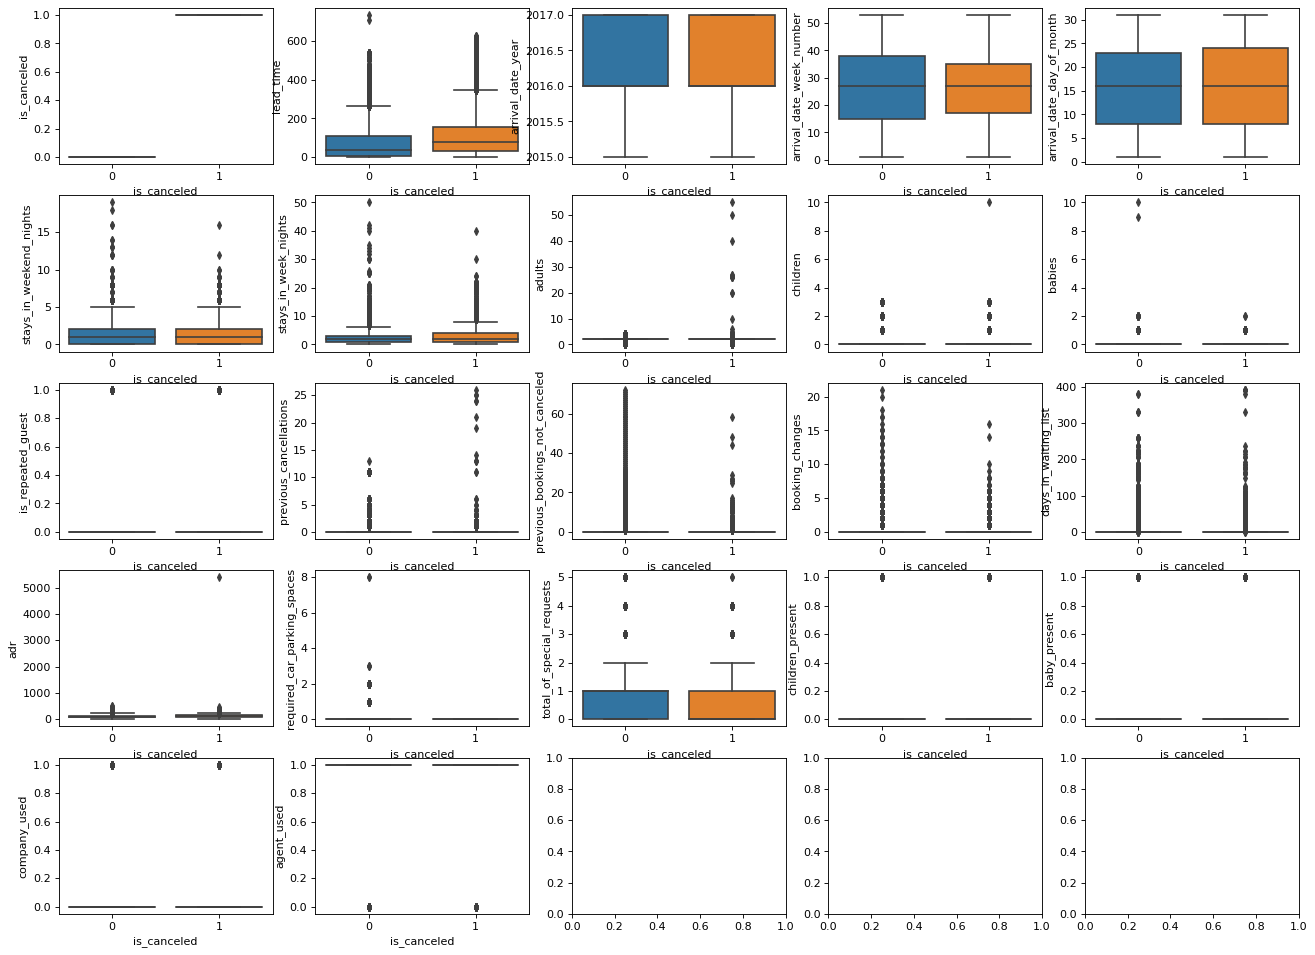

In [107]:
fig, ax2 = plt.subplots(ncols = 5, nrows =5, figsize = (20, 15))
ax2 = ax2.ravel()
num_cols = df.select_dtypes(["int64", "float64", "int32", "float32"]).columns 

for i in range(len(num_cols)):
    sns.boxplot(y=num_cols[i], x = "is_canceled", data = df, ax = ax2[i])

Lastly, we'd like to look at correlations (for numerical variables since we can't look for categorical variables). This should help us decide which numerical variables to keep.

<AxesSubplot:>

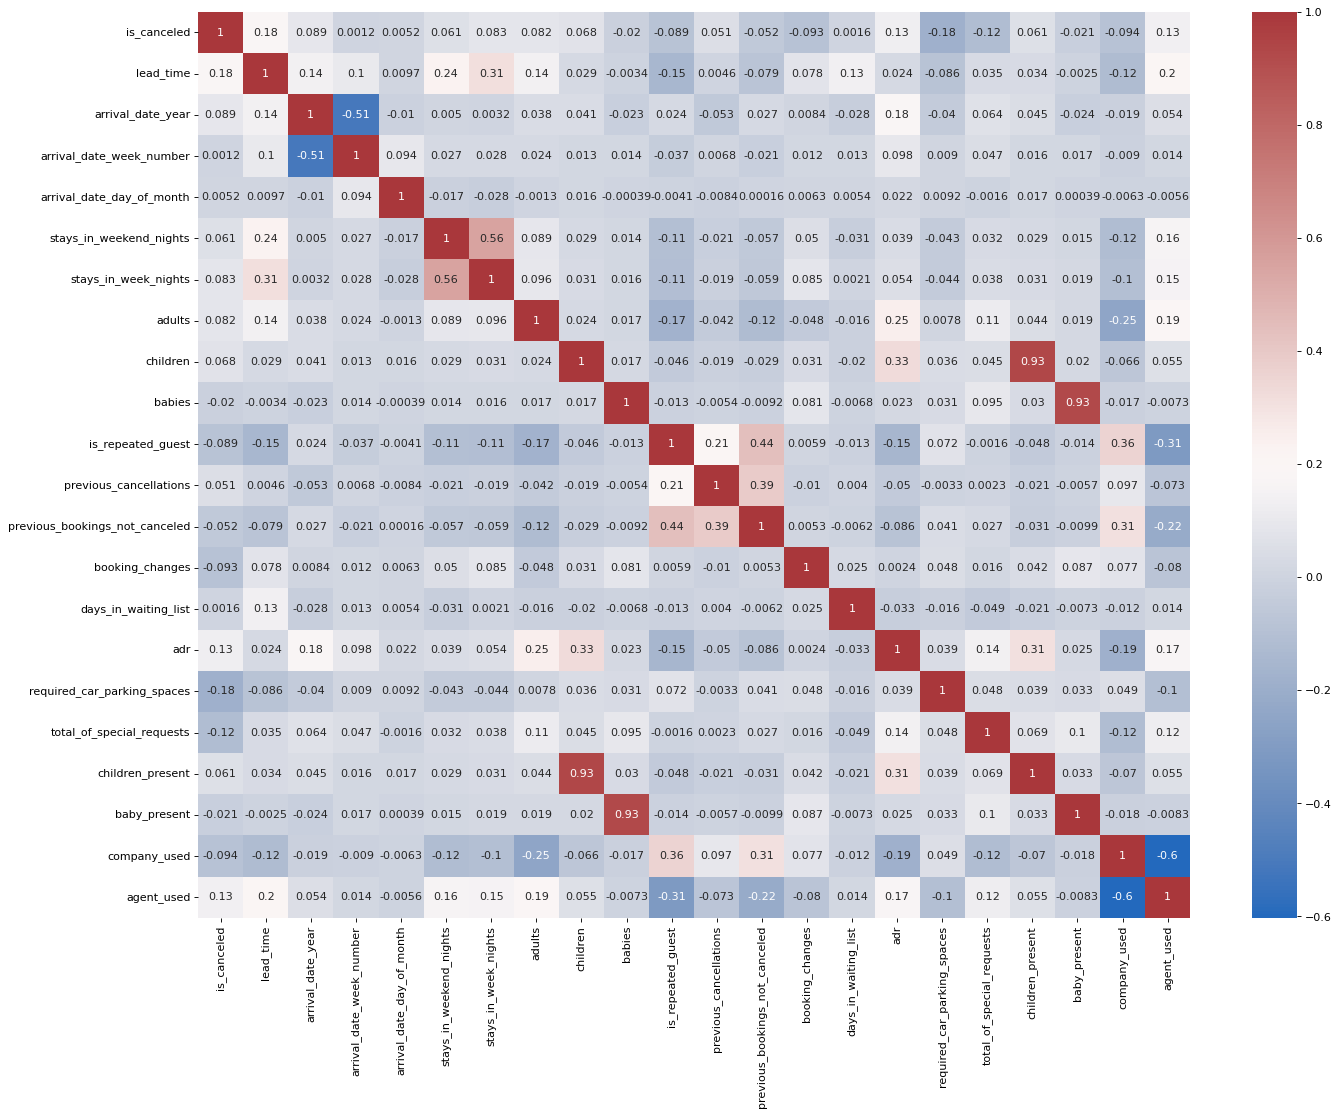

In [108]:
##correlation between numerical featuresONLY
plt.figure(figsize=(20, 15))
sns.heatmap(df.select_dtypes(["int64", "float64", "int32", "float32"]).corr(), annot = True, cmap = "vlag")


So far we have filled missing values (or dropped if the number was sufficiently small), 

We created binary variables for children, babies, company, and agent. However, the levels of these binary variables did not appear to have an affect on the cancellation status: The barplots show no difference and the correlation plot shows almost no correlation with cancellation status each except for agent_used (0.13). Even though agent_used has a fairly high correlation, the original column, "agent" contains this information in the "Not Used" level, so they contain the same information and one can be dropped. Since agent has so many levels, we will drop the original column and use the binary "agent_used" column. As such, we will drop all of the binary variables except "agent_used" in addition to the original "agent" column.

In [109]:
df = df.drop(columns = ["children_present", "baby_present", "company_used", "agent_used"])

Before OneHotEncoding (creating dummy variables), we need to save the names of the columns that we will want to standardize since the OneHotEncoding creates too many columns to deal with at once

In [110]:
#select columns that require scaling
##First we select all numeric variables, but these contain dummy variables, which we do not want to scall
##So then we identify dummy variables (All dummies are numeric, but binary)
##and select from numerics, if NOT a dummy variable

X_init = df.drop("is_canceled", axis = 1) ##remove the response variable because we don't want to scale
scale_col = X_init.select_dtypes(include = np.number).columns ##subset the numeric columns

##Manually specify the categorical variables with numeric values since there is no common pattern
numeric_cats = ["arrival_date_year", "arrival_date_week_number", "arrival_date_day_of_month", ##don't scale time series
               "is_repeated_guest"]

##select drop the numeric categoricals from scale_col
scale_col = [col for col in scale_col if col not in numeric_cats] ##update scale_col with true numeric variables

scale_col

['lead_time',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'days_in_waiting_list',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests']

In [111]:
#OneHotEncoding 
df.reset_index(inplace=True, drop = True)

ohe_col = df.select_dtypes(exclude = np.number).columns
ohe = OneHotEncoder(sparse = False)
dohe = ohe.fit_transform(df[ohe_col])
dohe = pd.DataFrame(dohe)
dohe.columns = ohe.get_feature_names_out()
df = pd.concat([df,dohe], axis = 1).drop(ohe_col, axis = 1)
df.to_csv("../full_dat.csv")

Read in the fully transformed data

In [112]:
# df = pd.read_csv("../full_dat.csv")

In [113]:
type(scale_col)

list

In [114]:
pd.set_option('display.max_columns', None)
print(X_train.columns[1:60])
print(f'Number of Columns: {len(X_train.columns)}')

Index(['arrival_date_year', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes',
       'days_in_waiting_list', 'adr', 'required_car_parking_spaces',
       'total_of_special_requests', 'hotel_City Hotel', 'hotel_Resort Hotel',
       'arrival_date_month_April', 'arrival_date_month_August',
       'arrival_date_month_December', 'arrival_date_month_February',
       'arrival_date_month_January', 'arrival_date_month_July',
       'arrival_date_month_June', 'arrival_date_month_March',
       'arrival_date_month_May', 'arrival_date_month_November',
       'arrival_date_month_October', 'arrival_date_month_September', 'meal_BB',
       'meal_FB', 'meal_HB', 'meal_SC', 'meal_Undefined', 'country_ABW',
       'country_AGO', 'country_AIA', 'country_ALB', 'country_AND',
       'countr

Splitting and Standardizing Data

Note that we have already selected the columns to standardize before performing OneHotEncoding.

In [ ]:
SEED = 332

##Split Data
#ESeparate response and explanatory data
X= df.drop("is_canceled", axis = 1) ##drop the response data from x
y = df["is_canceled"] ##select the response data

X = X.reset_index(drop = True)##reset indices on X

#Split data into train and test sets 
##We have a very large test set, so we don't need a very large test size
##We have an imbalanced dataset with more cancellations than non-cancellations, so we need to do a stratified split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.11, random_state = SEED, stratify = y)

##Standardize data

##create copies to transform and keep as standardized data
std_train = X_train.copy() 
std_test = X_test.copy() 

# create pipeline for scalers
std_scale = Pipeline([('standard', StandardScaler())]) ##standardized scaling

##fit to training data (only scale columns)
std_scale.fit(X_train[scale_col]) ##fit to the training data

##transform training and test scale cols accroding to train data
std_train[scale_col] = std_scale.transform(std_train[scale_col])
std_test[scale_col] = std_scale.transform(std_test[scale_col])

##write to csv
std_train.to_csv(f"./X_train_std.csv", index=False)
std_test.to_csv(f"./X_test_std.csv", index=False)

In [93]:
std_train.head()

,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,hotel_City Hotel,hotel_Resort Hotel,arrival_date_month_April,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September,meal_BB,meal_FB,meal_HB,meal_SC,meal_Undefined,country_ABW,country_AGO,country_AIA,country_ALB,country_AND,country_ARE,country_ARG,country_ARM,country_ASM,country_ATA,country_ATF,country_AUS,country_AUT,country_AZE,country_BDI,country_BEL,country_BEN,country_BFA,country_BGD,country_BGR,country_BHR,country_BHS,country_BIH,country_BLR,country_BOL,country_BRA,country_BRB,country_BWA,country_CAF,country_CHE,country_CHL,country_CHN,country_CIV,country_CMR,country_CN,country_COL,country_COM,country_CPV,country_CRI,country_CUB,country_CYM,country_CYP,country_CZE,country_DEU,country_DJI,country_DMA,country_DNK,country_DOM,country_DZA,country_ECU,country_EGY,country_ESP,country_EST,country_ETH,country_FIN,country_FJI,country_FRA,country_FRO,country_GAB,country_GBR,country_GEO,country_GGY,country_GHA,country_GIB,country_GLP,country_GNB,country_GRC,country_GTM,country_GUY,country_HKG,country_HND,country_HRV,country_HUN,country_IDN,country_IMN,country_IND,country_IRL,country_IRN,country_IRQ,country_ISL,country_ISR,country_ITA,country_JAM,country_JEY,country_JOR,country_JPN,country_KAZ,country_KEN,country_KHM,country_KIR,country_KNA,country_KOR,country_KWT,country_LAO,country_LBN,country_LBY,country_LCA,country_LIE,country_LKA,country_LTU,country_LUX,country_LVA,country_MAC,country_MAR,country_MCO,country_MDG,country_MDV,country_MEX,country_MKD,country_MLI,country_MLT,country_MMR,country_MNE,country_MOZ,country_MRT,country_MUS,country_MWI,country_MYS,country_MYT,country_NAM,country_NCL,country_NGA,country_NIC,country_NLD,country_NOR,country_NPL,country_NZL,country_OMN,country_PAK,country_PAN,country_PER,country_PHL,country_PLW,country_POL,country_PRI,country_PRT,country_PRY,country_PYF,country_QAT,country_ROU,country_RUS,country_RWA,country_SAU,country_SDN,country_SEN,country_SGP,country_SLE,country_SLV,country_SMR,country_SRB,country_STP,country_SUR,country_SVK,country_SVN,country_SWE,country_SYC,country_SYR,country_TGO,country_THA,country_TJK,country_TMP,country_TUN,country_TUR,country_TWN,country_TZA,country_UGA,country_UKR,country_UMI,country_URY,country_USA,country_UZB,country_Undefined,country_VEN,country_VGB,country_VNM,country_ZAF,country_ZMB,country_ZWE,market_segment_Aviation,market_segment_Complementary,market_segment_Corporate,market_segment_Direct,market_segment_Groups,market_segment_Offline TA/TO,market_segment_Online TA,distribution_channel_Corporate,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,distribution_channel_Undefined,reserved_room_type_A,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,reserved_room_type_H,reserved_room_type_L,reserved_room_type_P,assigned_room_type_A,assigned_room_type_B,assigned_room_type_C,assigned_room_type_D,assigned_room_type_E,assigned_room_type_F,assigned_room_type_G,assigned_room_type_H,assigned_room_type_I,assigned_room_type_K,assigned_room_type_L,assigned_room_type_P,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,agent_1.0,agent_10.0,agent_103.0,agent_104.0,agent_105.0,agent_106.0,agent_107.0,agent_11.0,agent_110.0,agent_111.0,agent_112.0,agent_114.0,agent_115.0,agent_117.0,agent_118.0,agent_119.0,agent_12.0,agent_121.0,agent_122.0,agent_126.0,agent_127.0,agent_128.0,agent_129.0,agent_13.0,agent_132.0,a

## 3. Model Fitting and Tuning

*In this section you should detail your choice of model and describe the process used to refine and fit that model. You are strongly encouraged to explore many different modeling methods (e.g. logistic regression, classification trees, SVC, etc.) but you should not include a detailed narrative of all of these attempts. At most this section should mention the methods explored and why they were rejected - most of your effort should go into describing the model you are using and your process for tuning and validatin it.*

*This section should also include the full implementation of your final model, including all necessary validation. As with figures, any included code must also be addressed in the text of the document.*

## 4. Discussion & Conclusions


*In this section you should provide a general overview of your final model, its performance, and reliability. You should discuss what the implications of your model are in terms of the included features, predictive performance, and anything else you think is relevant.*

*This should be written with a target audience of the client who is with the hotel data and university level mathematics but not necessarily someone who has taken a postgraduate statistical modeling course. Your goal should be to convince this audience that your model is both accurate and useful.*

*Keep in mind that a negative result, i.e. a model that does not work well predictively, that is well explained and justified in terms of why it failed will likely receive higher marks than a model with strong predictive performance but with poor or incorrect explinations / justifications.*